# CREDIT CARD APPROVAL PREDICTION #


# Context #

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.

#### Task: #### 
Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique to construct you label. Also, unbalance data problem is a big problem in this task.

The data come from kaggle.com: https://www.kaggle.com/rikdifos/credit-card-approval-prediction


# Solution: #

The data is not small, so we will use PySpark to develop our application. We divide this problem into two phases:

## Phase 1: Labeling data ##

As the data that we have is not enough information to apply credit score methods such as Fico score or Vintage analysis. So, we will use the clustering method to partition customers. This method allows us to cluster objectively customers based on historical data.  We will perform two process of clustering to filter 'Good' or 'Bad' clients:
* First clustering: we use the informations such as the percentages of no loan, paid off and number of past due months to filter the bad suspicion clients, they are input of the second step.
* Second clustering: we apply the length debt of clients such as the percentage of one due month, two due months, three due months, four due months, and five due months to cluster on the bad suspicion clients. After this step, we will determine 'bad' clients.

By applying two-steps clustering helps us to take a careful look at the data before making decision that a customer is good or bad.

## Phase 2: Modeling and prediction ##

After labeling data, we will build the models such as LSVC, Logistic Regression, Naive Bayes, GBT, Decision Tree and Random Forest to predict that a customer is good or bad. To solve the imbalanced problem, we will use “balancing” class weights method. It's very simple and effective.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,MinMaxScaler, UnivariateFeatureSelector
from pyspark.sql.functions import col, lit, when, desc, mean
from pyspark.sql.types import *
from sklearn.metrics import confusion_matrix

In [2]:
# Using Kmean to cluster the clients
# Arguments: df - dataframe of clients
#            vector - vectorAssembler of features to analyze
def clustering_clients(df, vector):
    # Create Kmean model with 5 clusters
    kmeans = KMeans().setK(5).setSeed(1)
    # Initial MinMax Scaler object
    min_max_scaler = MinMaxScaler(inputCol="features", outputCol="features_norm")
    # Create pipeline with vector assembler, min max scaler and Kmean
    pipeline = Pipeline(stages=[vector, min_max_scaler, kmeans])
    #Fitting data
    model = pipeline.fit(df) 
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    pred= model.transform(df)
    silhouette = evaluator.evaluate(pred)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    # Drop features and features_norm columns
    columns_to_drop = ['features', 'features_norm']
    pred = pred.drop(*columns_to_drop)
    return pred

In [3]:
# Plot heatmap for number data
# Arguments: df is a number dataframe
def plot_heatmap(df):
    # Correlation between different variables
    corr = df.corr()
    # Set up the matplotlib plot configuration
    f, ax = plt.subplots(figsize=(12, 10))
    # Draw the heatmap
    sns.heatmap(corr, annot=True)

In [4]:
# Calculate correlation and plot heatmap
# Arguments:
# df: dataframe
# Cols: features to heatmap
def correlation_heatmap(df,cols):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=cols, outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(myGraph_vector, vector_col)

    matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
    corrmatrix = matrix.toArray().tolist()
    df_corr = pd.DataFrame(corrmatrix,columns=cols)
    plot_heatmap(df_corr)

In [5]:
# Add the "weight" column into dataframe df to solve imbalanced data
# Arguments:
# df: is a imbalanced dataframe
# target_col: name of target column, its values are '1' or '0'(string)
# Return: a dataframe contains the "weight" column (= df + "weight" column)
def add_weight_column(df, target_col):
    # Check imbalance and compute weights
    counts = df.groupBy(target_col).count().toPandas()
    #print(counts)

    # Counts
    count_best = counts[counts[target_col]==1]['count'].values[0]
    count_total = counts['count'].sum()

    # Weights
    c = 2
    '''
    # Good for lsvc model
    weight_best = (count_total / (c * count_best))*1.05
    weight_bad = (count_total / (c * (count_total - count_best)))
    '''
    '''
    # Good for Naive Bayes model
    weight_best = (count_total / (c * count_best))*1.4
    weight_bad = (count_total / (c * (count_total - count_best)))
    '''

    # Good for tree models
    weight_best = (count_total / (c * count_best))*1.7
    weight_bad = (count_total / (c * (count_total - count_best)))

    df = df.withColumn("weight", when(col(target_col) ==1, weight_best).otherwise(weight_bad))

    # Check everything seems ok
    #df.select(target_col, 'weight').where(col(target_col)=='1').show(3)
    #df.select(target_col, 'weight').where(col(target_col)=='0').show(3)
    
    return df

In [6]:
# Split randomly data make sure data of classes are splitted as given rate
def split_data(df,trainning_rate,testing_rate):
    df_class0 = df.filter("Class==0")
    df_class1 = df.filter("Class==1")
    splits0 = df_class0.randomSplit([trainning_rate, testing_rate])
    df_train0 = splits0[0]
    df_test0 = splits0[1]
    splits1 = df_class1.randomSplit([trainning_rate, testing_rate])
    df_train1 = splits1[0]
    df_test1 = splits1[1]
    return([df_train0.union(df_train1),df_test0.union(df_test1)])

In [7]:
# One hot data
def one_hot_pipeline(df,cols):
    onehot_stages = []
    for col in cols:
        encoder = OneHotEncoder(inputCols=[col+'Index'], outputCols=[col+'Vector'])
        onehot_stages += [encoder]
    onehot_pipeline = Pipeline().setStages(onehot_stages)
    model_pipeline = onehot_pipeline.fit(df)
    return model_pipeline.transform(df)

In [8]:
# String Index data
def stringIndex_pipeline(df,cols):
    index_stages = []
    for col in cols:
        indexer = StringIndexer(inputCol=col, outputCol=col+'Index')
        index_stages += [indexer]
    str_index_pipeline = Pipeline().setStages(index_stages)
    model_pipeline = str_index_pipeline.fit(df)
    return model_pipeline.transform(df)
    

In [9]:
# Training and get accuracy and confusion matrix of models: Lsvc, lr, gbt, decision tree, random forest and naive bayes
# Arguments:
# df_train: training dataframe
# df_test: testing dataframe
# numeric_cols: list of numeric columns (features)
# categorical_cols: list of categorical columns (features)
# Return: a dictionary contains accuracy and confusion matrix of models.
def get_accuracy_models(df_train,df_test,numeric_cols,categorical_cols):
    
    models_dict = {
        0: ['Logistic Regression', 'lr_pred'],
        1: ['LSVC', 'lsvc_pred'],
        2: ['Naive Bayes', 'nb_pred'],
        3: ['GBT', 'gbt_pred'],
        4: ['Decision Tree', 'dt_pred'],
        5: ['Random Forest', 'rf_pred']
    }
    # String Index 'Class' target variable
    indexer = StringIndexer(inputCol="Class", outputCol="label")
    # Vectoc Assembler for all numeric features
    num_vector = VectorAssembler(inputCols=numeric_cols,outputCol="num_features")
    # Vector Assembler for all categorical features
    cate_vector = VectorAssembler(inputCols=[c+'Vector' for c in categorical_cols],outputCol="cate_features")
    # Normalization for all numeric features
    num_normalizer = MinMaxScaler(inputCol="num_features", outputCol="num_features_norm")
    # Normalization for all categorical features
    cate_normalizer = MinMaxScaler(inputCol="cate_features", outputCol="cate_features_norm")
    # User feature selector to select two best numeric features
    num_selector = UnivariateFeatureSelector(featuresCol="num_features_norm", outputCol="num_selectedFeatures",
                                     labelCol="label", selectionMode="numTopFeatures")
    num_selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(2)
     # User feature selector to select four best categorical features
    cate_selector = UnivariateFeatureSelector(featuresCol="cate_features_norm", outputCol="cate_selectedFeatures",
                                     labelCol="label", selectionMode="numTopFeatures")
    cate_selector.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(4)
    # Vector Assembler for all selected features
    vectorAssembler = VectorAssembler(inputCols=["num_selectedFeatures","cate_selectedFeatures"],\
                                      outputCol="features")
    
    # LSVC
    from pyspark.ml.classification import LinearSVC
    lsvc = LinearSVC(labelCol="label", featuresCol="features", weightCol="weight", predictionCol=models_dict[1][1],\
                     rawPredictionCol='raw_'+models_dict[1][1], maxIter=10, regParam=0.1)

    # GBTClassifier  
    from pyspark.ml.classification import GBTClassifier
    gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol="weight",\
                        predictionCol=models_dict[3][1], maxIter=10)

    # Logistic Regression
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="weight",\
                            predictionCol=models_dict[0][1], maxIter=10, regParam=0.3,\
                            rawPredictionCol='raw_'+models_dict[0][1], probabilityCol='prob_'+models_dict[0][1],elasticNetParam=0.8)


    # DecisionTree
    from pyspark.ml.classification import DecisionTreeClassifier
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", weightCol="weight",\
                                predictionCol=models_dict[4][1], rawPredictionCol='raw_'+models_dict[4][1],\
                               probabilityCol='prob_'+models_dict[4][1])

    # RandomForest
    from pyspark.ml.classification import RandomForestClassifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="weight",\
                                predictionCol=models_dict[5][1], rawPredictionCol='raw_'+models_dict[5][1],\
                                probabilityCol='prob_'+models_dict[5][1],numTrees=10)

    # Naive Bayes
    from pyspark.ml.classification import NaiveBayes
    nb = NaiveBayes(labelCol="label", featuresCol="features", weightCol="weight", smoothing=1.0, \
                    predictionCol=models_dict[2][1], rawPredictionCol='raw_'+models_dict[2][1], \
                    probabilityCol='prob_'+models_dict[2][1], modelType="multinomial")

    # Create pipeline
    pipeline = Pipeline(stages=[indexer, num_vector, cate_vector, num_normalizer, cate_normalizer,\
                                num_selector, cate_selector, vectorAssembler, lr, lsvc, nb, gbt, dt, rf])
    # Fitting data
    pipe_model = pipeline.fit(df_train)
    # Prediction
    prediction = pipe_model.transform(df_test).select("label",models_dict[0][1],models_dict[1][1],\
                                models_dict[2][1],models_dict[3][1],models_dict[4][1],models_dict[5][1])
    # Get true value
    y_true = prediction.select(['label']).collect()
    # Loop for all models to calculate accuracy and confusion matrix
    for key in models_dict:
        y_pred = prediction.select([models_dict[key][1]]).collect()
        
        eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol=models_dict[key][1],\
                                                          metricName="accuracy")
        
        models_dict[key].append(eval_accuracy.evaluate(prediction))
        models_dict[key].append(confusion_matrix(y_true, y_pred))
    # return the result dictionary    
    return models_dict

In [10]:
# Import spark context, configure
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [11]:
# Get spark context
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

21/12/27 12:36:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Phase 1: Labeling data ##

In [12]:
# create a dataframe out of it
df_credit = spark.read.format("csv").option("header", "true").load("credit_record.csv")
# register a corresponding query table
df_credit.createOrReplaceTempView('credit_record')
# Filter the client non overdue
df_non_overdue = spark.sql("select * from credit_record where ID not in \
                            (select distinct(ID) from credit_record where STATUS ='5')")
# Create a table for non overdue clients
df_non_overdue.createOrReplaceTempView('credit_record_non_overdue')

In [13]:
# Count the number of months of non overdue clients
df_summary = spark.sql("select ID, count(*) as months from credit_record_non_overdue group by ID")

In [14]:
df_summary.toPandas()

,ID,months
0,5001858,32
1,5002083,20
2,5002574,12
3,5003166,13
4,5003224,58
...,...,...
45785,5149472,44
45786,5149651,30
45787,5149870,12
45788,5149876,16


In [15]:
# Count the number of past due months of clients
df_due_months = spark.sql("select ID, count(*) as due_months from credit_record_non_overdue \
                          where !((STATUS=='C') or (STATUS=='X')) \
                          group by ID")

In [16]:
# Count the number of one past due months of clients
df_one_due_month = spark.sql("select ID, count(*) as one_due_month from credit_record_non_overdue \
                                    where STATUS=='0' group by ID")

In [17]:
# Count the number of two past due months of clients
df_two_due_months = spark.sql("select ID, count(*) as two_due_months from credit_record_non_overdue \
                                    where STATUS=='1' group by ID")

In [18]:
# Count the number of three past due months of clients
df_three_due_months = spark.sql("select ID, count(*) as three_due_months from credit_record_non_overdue \
                                    where STATUS=='2' group by ID")

In [19]:
# Count the number of four past due months of clients
df_four_due_months = spark.sql("select ID, count(*) as four_due_months from credit_record_non_overdue \
                                    where STATUS=='3' group by ID")

In [20]:
# Count the number of five past due months of clients
df_five_due_months = spark.sql("select ID, count(*) as five_due_months from credit_record_non_overdue \
                                    where STATUS=='4' group by ID")

In [21]:
# Count the number of paid off months of clients
df_paid_off_months = spark.sql("select ID, count(*) as paid_off_months from credit_record_non_overdue \
                                    where STATUS=='C' group by ID")

In [22]:
# Count the number of no loan months of clients
df_no_loan_months = spark.sql("select ID, count(*) as no_loan_months from credit_record_non_overdue \
                                    where STATUS=='X' group by ID")

In [23]:
# Join all data to a summary dataframe
df_summary = df_summary.join(df_no_loan_months, df_summary.ID == df_no_loan_months.ID, 'outer')\
                       .select(df_summary['*'], df_no_loan_months.no_loan_months) 
df_summary = df_summary.join(df_paid_off_months, df_summary.ID == df_paid_off_months.ID, 'outer')\
                       .select(df_summary['*'], df_paid_off_months.paid_off_months) 
df_summary = df_summary.join(df_due_months, df_summary.ID == df_due_months.ID, 'outer')\
                       .select(df_summary['*'], df_due_months.due_months) 
df_summary = df_summary.join(df_one_due_month, df_summary.ID == df_one_due_month.ID, 'outer')\
                       .select(df_summary['*'], df_one_due_month.one_due_month) 
df_summary = df_summary.join(df_two_due_months, df_summary.ID == df_two_due_months.ID, 'outer')\
                       .select(df_summary['*'], df_two_due_months.two_due_months) 
df_summary = df_summary.join(df_three_due_months, df_summary.ID == df_three_due_months.ID, 'outer')\
                       .select(df_summary['*'], df_three_due_months.three_due_months) 
df_summary = df_summary.join(df_four_due_months, df_summary.ID == df_four_due_months.ID, 'outer')\
                       .select(df_summary['*'], df_four_due_months.four_due_months) 
df_summary = df_summary.join(df_five_due_months, df_summary.ID == df_five_due_months.ID, 'outer')\
                       .select(df_summary['*'], df_five_due_months.five_due_months) 

In [24]:
# Replace NaN to 0
df_summary = df_summary.na.fill(value=0)

In [25]:
# Convert the number of months to percentage
df_summary = df_summary.withColumn("one_due_month", when(col("due_months")!=0, col("one_due_month")*100 / col("due_months")).otherwise(0))
df_summary = df_summary.withColumn("two_due_months", when(col("due_months")!=0, col("two_due_months")*100 / col("due_months")).otherwise(0))
df_summary = df_summary.withColumn("three_due_months", when(col("due_months")!=0, col("three_due_months")*100 / col("due_months")).otherwise(0))
df_summary = df_summary.withColumn("four_due_months", when(col("due_months")!=0, col("four_due_months")*100 / col("due_months")).otherwise(0))
df_summary = df_summary.withColumn("five_due_months", when(col("due_months")!=0, col("five_due_months")*100 / col("due_months")).otherwise(0))
df_summary = df_summary.withColumn("no_loan_months", when(col("months")!=0, col("no_loan_months")*100 / col("months")).otherwise(0))
df_summary = df_summary.withColumn("paid_off_months", when(col("months")!=0, col("paid_off_months")*100 / col("months")).otherwise(0))
df_summary = df_summary.withColumn("due_months", when(col("months")!=0, col("due_months")*100 / col("months")).otherwise(0))

In [26]:
df_summary.toPandas().head()

,ID,months,no_loan_months,paid_off_months,due_months,one_due_month,two_due_months,three_due_months,four_due_months,five_due_months
0,5001858,32,0.000000,62.500000,37.500000,100.0,0.0,0.0,0.0,0.0
1,5002083,20,0.000000,80.000000,20.000000,100.0,0.0,0.0,0.0,0.0
2,5002574,12,0.000000,0.000000,100.000000,100.0,0.0,0.0,0.0,0.0
3,5003166,13,7.692308,61.538462,30.769231,100.0,0.0,0.0,0.0,0.0
4,5003224,58,0.000000,79.310345,20.689655,100.0,0.0,0.0,0.0,0.0


### Important Notes ###
To filter 'good' or 'bad' clients, we will perform two process of clustering:
* First clustering: we use the informations such as the percentages of no loan, paid off and number of past due months to filter the bad suspicion clients, they are input of the second step.
* Second clustering: we apply the length debt of clients such as the percentage of one due month, two due months, three due months, four due months, and five due months to cluster on the bad suspicion clients. After this step, we will determine 'bad' clients.

### Fisrt Clustering: Determine the bad suspicion clients ###

In [27]:
# Clustering clients by percentage of no loan months, paid off months, due months.
vectorAssembler = VectorAssembler(inputCols=["no_loan_months","paid_off_months", "due_months"],
                                  outputCol="features")
# Clustering
predictions = clustering_clients(df_summary,vectorAssembler)

21/12/27 12:37:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/27 12:37:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Silhouette with squared euclidean distance = 0.7760094267242679


In [28]:
# register a corresponding query table
predictions.createOrReplaceTempView('percentage_due_months')
# Statistics by mean of number of months, no loan months, paid off months and number of past due months on clusters
df_percentage_due_months = spark.sql("select count(*), avg(months), avg(no_loan_months), avg(paid_off_months), \
                                      avg(due_months), prediction from percentage_due_months group by prediction")
df_percentage_due_months.toPandas()

,count(1),avg(months),avg(no_loan_months),avg(paid_off_months),avg(due_months),prediction
0,6086,23.221328,95.631171,1.582404,2.786425,1
1,5196,17.255581,46.810659,1.442542,51.746799,3
2,7258,24.021494,3.346580,47.574898,49.078522,4
3,12914,33.195911,3.387015,80.069743,16.543242,2
4,14336,14.488770,6.007811,1.984874,92.007315,0


### Analysis of first clustering result: ###
The above result show that:
* The cluster with prediction = 2 is the best clients because they have the highest percentage of paid-off of months with 80% and low percentage of past due months (16.5%)
* The cluster with prediction = 1 is the client of "no loan" months, they are not bad
* The clusters with prediction = 0 or 3 or 4 are the clients of bad suspicion because they have low percentage of paid-off months and high past due months. So we filter these clusters to perform again clustering in second step to get the bad clients.

### Second Clustering: Determine the bad clients ###

In [29]:
# Determine the bad suspicion clients
df_bad_suspicion = spark.sql("select * from percentage_due_months where prediction in (0,3,4)")
# Drop prediction column
df_bad_suspicion = df_bad_suspicion.drop(*['prediction'])

In [30]:
# Dertermine the features to analysis
# In this step, we will the length debt of clients to analyze such as one due month, two due months,
# three due months, four due months and five due months
vectorAssembler = VectorAssembler(inputCols=["one_due_month","two_due_months","three_due_months",\
                                             "four_due_months","five_due_months"],
                                  outputCol="features")

# Clustering clients by length debt
pred_length_debt = clustering_clients(df_bad_suspicion,vectorAssembler)

Silhouette with squared euclidean distance = 0.9332107415162147


In [31]:
# register a corresponding query table
pred_length_debt.createOrReplaceTempView('length_debt')
# Statistics by mean of past due of months, one due month, two due months, three due months, four due months and
# five due months
df_length_debt = spark.sql("select count(*), avg(due_months),\
                              avg(one_due_month), avg(two_due_months), avg(three_due_months),\
                              avg(four_due_months), avg(five_due_months), prediction \
                              from length_debt group by prediction")
df_length_debt.toPandas()

,count(1),avg(due_months),avg(one_due_month),avg(two_due_months),avg(three_due_months),avg(four_due_months),avg(five_due_months),prediction
0,1097,74.011141,76.396173,22.484859,0.798537,0.192459,0.127973,1
1,1982,73.884898,90.076700,9.432548,0.383413,0.080976,0.026363,3
2,79,65.095425,19.874252,75.726436,3.645235,0.595849,0.158228,4
3,381,73.551832,52.233300,43.333059,3.457176,0.730766,0.245698,2
4,23251,72.397285,99.916587,0.075423,0.007487,0.000502,0.000000,0


### Analysis of second clustering result: ###
* The cluster with prediction = 0 is not bad, they are main customers of the system. They almost paid off the loan in one due month with 99.9%
* The other clusters are bad, their repayment extends into the 2nd and 3rd months... So we determine them bad customers.

In [32]:
# Filter the bad customers
df_bad_length_debt_clients = spark.sql("select ID from length_debt where prediction!=0")

In [33]:
# The overdue customers are also bad customers, so we will filter them.
df_overdue_months = spark.sql("select ID from credit_record \
                                    where STATUS=='5' group by ID")

In [34]:
# Determine the list of full bad clients.
df_bad_clients = df_overdue_months.union(df_bad_length_debt_clients).dropDuplicates()

In [35]:
# We assign the bad clients to Class = 0 
df_bad_clients = df_bad_clients.withColumn("Class",lit(0))

In [36]:
# Get list ID of all clients in credit_record table
df_all_clients = spark.sql("select distinct(ID) from credit_record group by ID")

In [37]:
# Join labeled bad clients to all clients list
df_all_clients = df_all_clients.join(df_bad_clients, df_all_clients.ID == df_bad_clients.ID, 'outer')\
.select(df_all_clients.ID, df_bad_clients.Class) 

In [38]:
# Assign the NaN value in Class column to 1 for good clients.
df_all_clients = df_all_clients.na.fill(value=1)
df_all_clients.toPandas()

,ID,Class
0,5001858,1
1,5002083,1
2,5002574,1
3,5003166,1
4,5003224,1
...,...,...
45980,5149364,1
45981,5149472,1
45982,5149651,1
45983,5149870,1


### Important Note ###
We determined a labeled list of clients through credit_record.csv file, now we will join this list with the list of application records to get a full list of labeled simples. These simples are the input to build a machine learning model to predict if an applicant is 'good' or 'bad' client.

In [39]:
customShema = StructType([StructField('ID', IntegerType(), False),
                          StructField('CODE_GENDER', StringType(), True),
                          StructField('FLAG_OWN_CAR', StringType(), True),
                          StructField('FLAG_OWN_REALTY', StringType(), True),
                          StructField('CNT_CHILDREN', IntegerType(), True),
                          StructField('AMT_INCOME_TOTAL', DoubleType(), True),
                          StructField('NAME_INCOME_TYPE', StringType(), True),
                          StructField('NAME_EDUCATION_TYPE', StringType(), True),
                          StructField('NAME_FAMILY_STATUS', StringType(), True),
                          StructField('NAME_HOUSING_TYPE', StringType(), True),
                          StructField('DAYS_BIRTH', IntegerType(), True),
                          StructField('DAYS_EMPLOYED', IntegerType(), True),
                          StructField('FLAG_MOBIL', IntegerType(), True),
                          StructField('FLAG_WORK_PHONE', IntegerType(), True),
                          StructField('FLAG_PHONE', IntegerType(), True),
                          StructField('FLAG_EMAIL', IntegerType(), True),
                          StructField('OCCUPATION_TYPE', StringType(), True),
                          StructField('CNT_FAM_MEMBERS', FloatType(), True)
                          ])

In [40]:
df_applicants = spark.read.format("csv").option("header", "true")\
                                        .option("delimiter", ",")\
                                        .schema(customShema).load("application_record.csv")

In [41]:
df_applicants.describe('CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL').show()

+-------+-----------+------------+---------------+-------------------+------------------+
|summary|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|       CNT_CHILDREN|  AMT_INCOME_TOTAL|
+-------+-----------+------------+---------------+-------------------+------------------+
|  count|     438557|      438557|         438557|             438557|            438557|
|   mean|       null|        null|           null|0.42739028222101116| 187524.2860095039|
| stddev|       null|        null|           null|  0.724882213552147|110086.85306622912|
|    min|          F|           N|              N|                  0|           26100.0|
|    max|          M|           Y|              Y|                 19|         6750000.0|
+-------+-----------+------------+---------------+-------------------+------------------+



In [42]:
df_applicants.describe('NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH'\
                    ).show()

+-------+--------------------+--------------------+------------------+-----------------+-------------------+
|summary|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|         DAYS_BIRTH|
+-------+--------------------+--------------------+------------------+-----------------+-------------------+
|  count|              438557|              438557|            438557|           438557|             438557|
|   mean|                null|                null|              null|             null|-15997.904648654565|
| stddev|                null|                null|              null|             null|  4185.030006794093|
|    min|Commercial associate|     Academic degree|    Civil marriage|  Co-op apartment|             -25201|
|    max|             Working|Secondary / secon...|             Widow|     With parents|              -7489|
+-------+--------------------+--------------------+------------------+-----------------+-------------------+



In [43]:
df_applicants.describe('DAYS_EMPLOYED','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL').show()

+-------+------------------+----------+-------------------+-------------------+-------------------+
|summary|     DAYS_EMPLOYED|FLAG_MOBIL|    FLAG_WORK_PHONE|         FLAG_PHONE|         FLAG_EMAIL|
+-------+------------------+----------+-------------------+-------------------+-------------------+
|  count|            438557|    438557|             438557|             438557|             438557|
|   mean| 60563.67532840657|       1.0| 0.2061328402009317|0.28777103090362255|0.10820714297115312|
| stddev|138767.79964666892|       0.0|0.40452745955008695|0.45272434441461806|0.31064220128266806|
|    min|            -17531|         1|                  0|                  0|                  0|
|    max|            365243|         1|                  1|                  1|                  1|
+-------+------------------+----------+-------------------+-------------------+-------------------+



In [44]:
df_unemployment = df_applicants.filter("DAYS_EMPLOYED==365243")

In [45]:
df_unemployment.groupby("OCCUPATION_TYPE").count().show()

+---------------+-----+
|OCCUPATION_TYPE|count|
+---------------+-----+
|           null|75329|
+---------------+-----+



In [46]:
df_days_employed = df_applicants.filter("DAYS_EMPLOYED!=365243").select('DAYS_EMPLOYED')
df_days_employed.describe().show()

+-------+-------------------+
|summary|      DAYS_EMPLOYED|
+-------+-------------------+
|  count|             363228|
|   mean|-2623.0526996817425|
| stddev|  2399.514253151732|
|    min|             -17531|
|    max|                -12|
+-------+-------------------+



In [47]:
mean_value = df_days_employed.agg({'DAYS_EMPLOYED': 'avg'}).collect()[0][0]
print(mean_value)

-2623.0526996817425


In [48]:
df_count = df_days_employed.groupby('DAYS_EMPLOYED').count()
df_count = df_count.sort(desc("count"))
df_count.show()

+-------------+-----+
|DAYS_EMPLOYED|count|
+-------------+-----+
|         -218|  262|
|        -1678|  251|
|         -249|  241|
|         -978|  240|
|         -430|  238|
|         -209|  231|
|         -231|  231|
|         -232|  228|
|        -2317|  226|
|         -302|  224|
|         -187|  223|
|        -2514|  223|
|         -179|  222|
|         -270|  221|
|        -1672|  218|
|         -238|  217|
|         -116|  215|
|         -795|  212|
|         -217|  211|
|         -186|  210|
+-------------+-----+
only showing top 20 rows



In [49]:
most_value = df_count.collect()[0][1]
print(most_value)

262


In [50]:
median = df_days_employed.approxQuantile('DAYS_EMPLOYED',[0.5],0.1)[0]
print(median)

-2400.0


In [51]:
df_applicants = df_applicants.withColumn("DAYS_EMPLOYED", when(col("DAYS_EMPLOYED")==365243, median)\
                                         .otherwise(col("DAYS_EMPLOYED")))

In [52]:
df_applicants.describe('DAYS_EMPLOYED').show()

+-------+-------------------+
|summary|      DAYS_EMPLOYED|
+-------+-------------------+
|  count|             438557|
|   mean|-2584.7399220625825|
| stddev| 2185.3546584408764|
|    min|           -17531.0|
|    max|              -12.0|
+-------+-------------------+



In [53]:
df_applicants.describe('OCCUPATION_TYPE','CNT_FAM_MEMBERS').show()

+-------+--------------------+------------------+
|summary|     OCCUPATION_TYPE|   CNT_FAM_MEMBERS|
+-------+--------------------+------------------+
|  count|              304354|            438557|
|   mean|                null| 2.194465029631268|
| stddev|                null|0.8972073300563004|
|    min|         Accountants|               1.0|
|    max|Waiters/barmen staff|              20.0|
+-------+--------------------+------------------+



In [54]:
# Join the list of labeled clients with the list of applicants to get a full list of labeled simples.
df_simples = df_applicants.join(df_all_clients, df_applicants.ID == df_all_clients.ID,'inner')\
                                    .select(df_applicants['*'],df_all_clients['Class'])

In [55]:
'''
# Cast type of 'AMT_INCOME_TOTAL'column from Double to Integer
df_simples = df_simples.withColumn('AMT_INCOME_TOTAL', df_simples['AMT_INCOME_TOTAL'].cast(IntegerType()))
# Cast type of 'CNT_FAM_MEMBERS'column from Float to Integer
df_simples = df_simples.withColumn('CNT_FAM_MEMBERS', df_simples['CNT_FAM_MEMBERS'].cast(IntegerType()))
'''


"\n# Cast type of 'AMT_INCOME_TOTAL'column from Double to Integer\ndf_simples = df_simples.withColumn('AMT_INCOME_TOTAL', df_simples['AMT_INCOME_TOTAL'].cast(IntegerType()))\n# Cast type of 'CNT_FAM_MEMBERS'column from Float to Integer\ndf_simples = df_simples.withColumn('CNT_FAM_MEMBERS', df_simples['CNT_FAM_MEMBERS'].cast(IntegerType()))\n"

In [56]:
df_simples.toPandas().head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Class
0,5009033,F,N,N,0,255150.0,Pensioner,Incomplete higher,Civil marriage,Rented apartment,-18682,-2400.0,1,0,0,0,None,2.0,1
1,5009304,F,N,N,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-22061,-2400.0,1,0,0,0,None,1.0,1
2,5009355,F,N,N,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19692,-5273.0,1,1,1,0,Laborers,2.0,1
3,5009429,M,N,N,0,198000.0,Working,Secondary / secondary special,Single / not married,With parents,-8657,-1164.0,1,1,0,0,Laborers,1.0,1
4,5010070,F,N,Y,0,279000.0,State servant,Higher education,Single / not married,House / apartment,-11091,-617.0,1,0,0,1,Managers,1.0,1


In [57]:
df_simples.describe('CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL').show()

+-------+-----------+------------+---------------+-------------------+------------------+
|summary|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|       CNT_CHILDREN|  AMT_INCOME_TOTAL|
+-------+-----------+------------+---------------+-------------------+------------------+
|  count|      36457|       36457|          36457|              36457|             36457|
|   mean|       null|        null|           null|0.43031516581177826|186685.73666236937|
| stddev|       null|        null|           null| 0.7423669007186845| 101789.2264823466|
|    min|          F|           N|              N|                  0|           27000.0|
|    max|          M|           Y|              Y|                 19|         1575000.0|
+-------+-----------+------------+---------------+-------------------+------------------+



In [58]:
df_simples.describe('NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH'\
                    ).show()

+-------+--------------------+--------------------+------------------+-----------------+------------------+
|summary|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|        DAYS_BIRTH|
+-------+--------------------+--------------------+------------------+-----------------+------------------+
|  count|               36457|               36457|             36457|            36457|             36457|
|   mean|                null|                null|              null|             null|-15975.17338234084|
| stddev|                null|                null|              null|             null| 4200.549943759228|
|    min|Commercial associate|     Academic degree|    Civil marriage|  Co-op apartment|            -25152|
|    max|             Working|Secondary / secon...|             Widow|     With parents|             -7489|
+-------+--------------------+--------------------+------------------+-----------------+------------------+



In [59]:
df_simples.describe('DAYS_EMPLOYED','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL').show()

+-------+------------------+----------+-------------------+-------------------+-------------------+
|summary|     DAYS_EMPLOYED|FLAG_MOBIL|    FLAG_WORK_PHONE|         FLAG_PHONE|         FLAG_EMAIL|
+-------+------------------+----------+-------------------+-------------------+-------------------+
|  count|             36457|     36457|              36457|              36457|              36457|
|   mean|-2604.190224099624|       1.0|0.22552596209232795|0.29481306744932384|0.08972213840963326|
| stddev| 2151.879301161289|       0.0|0.41793395842567826|0.45596493881592776| 0.2857871875724885|
|    min|          -15713.0|         1|                  0|                  0|                  0|
|    max|             -17.0|         1|                  1|                  1|                  1|
+-------+------------------+----------+-------------------+-------------------+-------------------+



In [60]:
df_simples.describe('OCCUPATION_TYPE','CNT_FAM_MEMBERS').show()

+-------+--------------------+------------------+
|summary|     OCCUPATION_TYPE|   CNT_FAM_MEMBERS|
+-------+--------------------+------------------+
|  count|               25134|             36457|
|   mean|                null| 2.198452971994404|
| stddev|                null|0.9116861437101013|
|    min|         Accountants|               1.0|
|    max|Waiters/barmen staff|              20.0|
+-------+--------------------+------------------+



In [61]:
df_simples.groupby('OCCUPATION_TYPE').count().show()

+--------------------+-----+
|     OCCUPATION_TYPE|count|
+--------------------+-----+
|                null|11323|
|            Managers| 3012|
|            HR staff|   85|
|      Medicine staff| 1207|
|         Accountants| 1241|
|            Laborers| 6211|
|      Cleaning staff|  551|
|Private service s...|  344|
|             Drivers| 2138|
|         Sales staff| 3485|
|       Realty agents|   79|
|            IT staff|   60|
|      Security staff|  592|
|         Secretaries|  151|
|  Low-skill Laborers|  175|
|          Core staff| 3591|
|       Cooking staff|  655|
|High skill tech s...| 1383|
|Waiters/barmen staff|  174|
+--------------------+-----+



In [62]:
# Replace null value to 'Unknown' value in "OCCUPATION_TYPE" column
df_simples = df_simples.withColumn("OCCUPATION_TYPE", when(col("OCCUPATION_TYPE").isNull(),\
                                                'Unknown').otherwise(col("OCCUPATION_TYPE")))

In [63]:
df_simples.groupby('NAME_HOUSING_TYPE').count().show()

+-------------------+-----+
|  NAME_HOUSING_TYPE|count|
+-------------------+-----+
|  House / apartment|32548|
|Municipal apartment| 1128|
|    Co-op apartment|  168|
|   Rented apartment|  575|
|   Office apartment|  262|
|       With parents| 1776|
+-------------------+-----+



In [64]:
df_simples.groupby('NAME_FAMILY_STATUS').count().show()

+--------------------+-----+
|  NAME_FAMILY_STATUS|count|
+--------------------+-----+
|           Separated| 2103|
|             Married|25048|
|Single / not married| 4829|
|               Widow| 1532|
|      Civil marriage| 2945|
+--------------------+-----+



In [65]:
df_simples.groupby('NAME_EDUCATION_TYPE').count().show()

+--------------------+-----+
| NAME_EDUCATION_TYPE|count|
+--------------------+-----+
|     Academic degree|   32|
|   Incomplete higher| 1410|
|Secondary / secon...|24777|
|     Lower secondary|  374|
|    Higher education| 9864|
+--------------------+-----+



In [66]:
df_simples.groupby('NAME_INCOME_TYPE').count().show()

+--------------------+-----+
|    NAME_INCOME_TYPE|count|
+--------------------+-----+
|             Student|   11|
|Commercial associate| 8490|
|       State servant| 2985|
|             Working|18819|
|           Pensioner| 6152|
+--------------------+-----+



In [67]:
df_simples.write.option("header",True).csv("labeled_applicants")

## Phase 2: Modeling and prediction ##



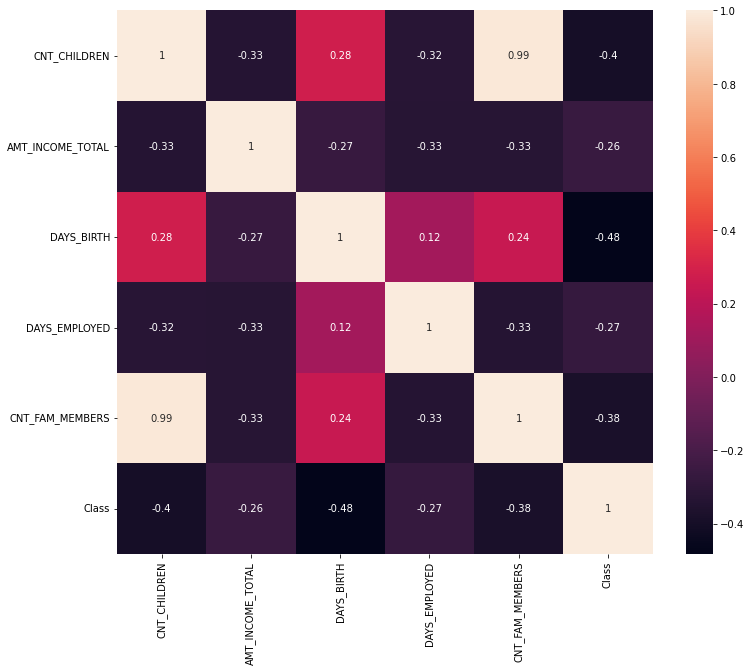

In [68]:
# Determine the numeric variables
numeric_cols_list = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'Class']
# Calculate the correlation between numeric variables
correlation_heatmap(df_simples.select(numeric_cols_list),numeric_cols_list)

The 'CNT_FAM_MEMBERS' have strong correlation with 'CNT_CHILDREN', so we will remove 'CNT_FAM_MEMBERS' from list of features

In [69]:
# Drop 'CNT_CHILDREN' from the list of features
df_simples = df_simples.drop('CNT_FAM_MEMBERS')
numeric_cols_list.remove('CNT_FAM_MEMBERS')
numeric_cols_list.remove('Class')

In [70]:
# Determine the categorical variables
categorical_cols_list = ['CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',\
                         'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',\
                         'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [71]:
# Add weight column to dataframe
df_simples = add_weight_column(df_simples,'Class')

In [72]:
# String Index for all categorical features
df_simples = stringIndex_pipeline(df_simples,categorical_cols_list)

In [73]:
# After String Index, we drop all categorical features from dataframe
df_simples = df_simples.drop(*categorical_cols_list)

In [74]:
# One hot encoding for all 'Index' categorical features
df_simples = one_hot_pipeline(df_simples,categorical_cols_list)

In [75]:
# After one hot, we drop all 'Index' categorical features from dataframe
for c in categorical_cols_list:
    df_simples = df_simples.drop(c+'Index')

In [76]:
# Split data to traning data and testing data
splits = split_data(df_simples,0.7,0.3)
df_train = splits[0]
df_test = splits[1]

In [77]:
# Training data, Building models and 
# get accuracy of models: Lsvc, lr, gbt, decision tree, random forest and naive bayes
summary_dict = get_accuracy_models(df_train,df_test,numeric_cols_list,categorical_cols_list)

In [78]:
# Print accuracy and confusion matrix of models
for model in summary_dict:
    print('============================================')
    print('Model: ', summary_dict[model][0])
    print('Accuracy: ', summary_dict[model][2])
    print('Confusion Matrix: ')
    print(summary_dict[model][3])

Model:  Logistic Regression
Accuracy:  0.9172540045766591
Confusion Matrix: 
[[10021     0]
 [  904     0]]
Model:  LSVC
Accuracy:  0.9172540045766591
Confusion Matrix: 
[[10021     0]
 [  904     0]]
Model:  Naive Bayes
Accuracy:  0.9172540045766591
Confusion Matrix: 
[[10021     0]
 [  904     0]]
Model:  GBT
Accuracy:  0.9030663615560641
Confusion Matrix: 
[[9808  213]
 [ 846   58]]
Model:  Decision Tree
Accuracy:  0.8745080091533181
Confusion Matrix: 
[[9459  562]
 [ 809   95]]
Model:  Random Forest
Accuracy:  0.9133180778032036
Confusion Matrix: 
[[9949   72]
 [ 875   29]]


21/12/27 14:56:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 992199 ms exceeds timeout 120000 ms
21/12/27 14:56:22 WARN SparkContext: Killing executors is not supported by current scheduler.


# Conclusion #

* The data that we have is not enough information to apply credit score methods such as Fico score or Vintage analysis. So, by using clustering method to partition customers is also a good idea, this method allows us to cluster objectively customers base on historical data.  We performed two process of clustering to filter 'Good' or 'Bad' clients:
    * First clustering: we use the informations such as the percentages of no loan, paid off and number of past due months to filter the bad suspicion clients, they are input of the second step.
    * Second clustering: we apply the length debt of clients such as the percentage of one due month, two due months, three due months, four due months, and five due months to cluster on the bad suspicion clients. After this step, we will determine 'bad' clients.
    
    By applying two-steps clustering helps us to take a careful look at the data before making decision that a customer is good or bad.
    

* After labeling data, we have built some models and obtained positive results. To solve the imbalanced problem, we used “balancing” class weights method and it's very simple and effective. These results show that the algorithms of trees such as GBT, Decision Tree and Random Forest are suitable for the imbalanced data classification problem. In contrast, the algorithms LSVC, Logistic regression or Naive Bayes are not suitable because they have bias towards the majority class. The best is ramdom forest with accuracy of 91.3%




### THANK YOU FOR READING ###
## AUTHOR ##
Tho Quy NGO